# Assignment

A total of 30 major cities are selected, with 10 from each region. The cities are as follows: 
- North America: New York, Washington DC, Boston, Houston, Chicago, Los Angeles, Seattle, San Francisco, Toronto, Vancouver
- Asia-Pacific: Tokyo, Osaka, Shanghai, Beijing, Seoul, Kuala Lumpur, Jakarta, Melbourne, Singapore, Bangkok
- Europe: London, Paris, Berlin, Frankfurt, Amsterdam, Madrid, Brussels, Copenhagen, Vienna, Zurich. 

It is assumed that the expatriates prefer to live downtown, want to have access to wide choice of good restaurants and bars as well as a selection of leisure activities including sports. Hence, factors to consider can be divided into two main groups, namely lifestyle (restaurants & bars, sports/gym facilities, parks, cinemas/theatres) and convenience (supermarket, laundry, public transport).


### Import and install necessary libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         238 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0        conda-forge
    geopy:         1.20.0-py_0      conda-forge

The following pac

### Define Foursquare Credentials and Version

In [2]:
CLIENT_ID = '3WLIIIZYVFXLBBMDPC1ZOQ1RWAYQOEQZFXRSJ2MUWR3ZP4PW' # your Foursquare ID
CLIENT_SECRET = 'AY5YR3IEC4J0LON5DE4VUYLZSWQUBC0ZXQ5Y4MLY1TMJSZ4U' # your Foursquare Secret
VERSION = '20190915'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3WLIIIZYVFXLBBMDPC1ZOQ1RWAYQOEQZFXRSJ2MUWR3ZP4PW
CLIENT_SECRET:AY5YR3IEC4J0LON5DE4VUYLZSWQUBC0ZXQ5Y4MLY1TMJSZ4U


### Define the location

In [3]:
cities = ['New York', 'Washington DC', 'Boston', 'Houston', 'Chicago', 'Los Angeles', 'Seattle', 'San Francisco', 'Toronto', 'Vancouver', 'Tokyo', 'Osaka', 'Shanghai', 'Beijing', 'Seoul', 'Kuala Lumpur', 'Jakarta', 'Melbourne', 'CBD Singapore', 'Bangkok Silom', 'London', 'Paris', 'Berlin', 'Frankfurt', 'Amsterdam', 'Madrid', 'Brussels', 'Copenhagen', 'Vienna', 'Zurich'] 
latitudes = np.zeros(len(cities))
longitudes = np.zeros(len(cities))
geolocator = Nominatim(user_agent="foursquare_agent")

for n in range(len(cities)):
    location = geolocator.geocode(cities[n])
    latitudes[n] = location.latitude
    longitudes[n] = location.longitude

### Define the functions

In [4]:
# Gives number of venues in the 8 categories
def getNumberVenues(latitude, longitude, radius=1000):
    search_query = ['restaurant','bar', 'fitness center', 'park', 'movie theatre', 'supermarket', 'Laundromat', 'Metro Station']
    numVenues = np.zeros(len(search_query))
    for n in range(len(search_query)):
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query[n], radius, LIMIT)
        results = requests.get(url).json()
        numVenues[n] = len(results['response']['venues'])
    return(numVenues)

In [11]:
# Gives the average number of likes for the restaurants
def getAvgNumberLikes(latitude, longitude, radius=1000):
    # For restaurants 
    search_query = ['restaurant']
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    restaurants = results['response']['venues']
       
    num_likes = np.zeros(len(restaurants))
    
    for n in range(len(restaurants)):
        venueID = restaurants[n]['id']
        url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(venueID,CLIENT_ID, CLIENT_SECRET,VERSION)
        results = requests.get(url).json()
        num_likes[n] = results['response']['likes']['count']
    
    avg_num_likes = np.mean(num_likes)
    
    return(avg_num_likes)

In [6]:
# Define a function that gives the variety score for the restaurants
def getVarietyScoreRestaurant(latitude, longitude, radius=1000):
    search_query = ['Asian', 'French', 'Italian', 'Vegetarian', 'steakhouse']
    variety_score = 0
    for n in range(len(search_query)):
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            latitude, 
            longitude, 
            VERSION, 
            search_query[n], 
            radius, 
            LIMIT)
        results = requests.get(url).json()
        if len(results['response']['venues'])>5:
            variety_score = variety_score+1
    return(variety_score)

In [49]:
numFeatures = 8+1+1 # 8 for number of categories, 1 for number of likes, 1 for variety score
X = np.zeros(shape=(len(cities),numFeatures))

## Generate the data

In [67]:
# Generate the data
for n in range(len(cities)):
    print(n)
    X[n,0:8] = getNumberVenues(latitudes[n], longitudes[n], radius=1000)    
    X[n,8:9] = getAvgNumberLikes(latitudes[n], longitudes[n], radius=1000)   
    X[n,9:11] = getVarietyScoreRestaurant(latitudes[n], longitudes[n], radius=1000)   

19
[50.   50.   50.   50.   20.    7.    0.   50.   15.44  5.  ]


In [102]:
data_df = pd.DataFrame({'restaurant': X[:, 0], 'bar': X[:, 1], 'fitness center': X[:, 2], 'park': X[:, 3],'movie theatre': X[:, 4], 'supermarket': X[:, 5],'laundromat': X[:, 6], 'metro station': X[:, 7],'avg likes (restaurants)': X[:, 8], 'variety score (restaurants)': X[:, 9]})
for n in range(30):
    data_df.rename(index={n: cities[n]},inplace=True)
data_df

,restaurant,bar,fitness center,park,movie theatre,supermarket,laundromat,metro station,avg likes (restaurants),variety score (restaurants)
New York,50.0,50.0,50.0,50.0,32.0,22.0,14.0,50.0,117.180000,4.0
Washington DC,35.0,50.0,50.0,50.0,10.0,0.0,0.0,50.0,149.314286,1.0
Boston,50.0,50.0,50.0,50.0,31.0,3.0,5.0,50.0,55.240000,2.0
Houston,37.0,50.0,50.0,50.0,15.0,0.0,0.0,50.0,28.675676,2.0
Chicago,50.0,50.0,50.0,50.0,50.0,0.0,0.0,50.0,60.240000,2.0
Los Angeles,50.0,50.0,50.0,50.0,26.0,1.0,1.0,50.0,42.900000,1.0
Seattle,50.0,50.0,50.0,50.0,24.0,2.0,0.0,50.0,63.020000,2.0
San Francisco,50.0,50.0,50.0,50.0,31.0,7.0,17.0,37.0,56.920000,3.0
Toronto,50.0,50.0,50.0,50.0,40.0,6.0,2.0,50.0,31.440000,4.0
Vancouver,38.0,39.0,35.0,39.0,5.0,0.0,3.0,9.0,18.394737,0.0


In [16]:
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

In [68]:
# Pre-processing the data
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[ 0.38761387,  0.29865183,  0.48722554,  0.617331  ,  1.02665901,
         3.77282231,  3.17048058,  0.55852083,  1.03434584,  1.27424023],
       [-1.90746825,  0.29865183,  0.48722554,  0.617331  , -0.47910754,
        -0.74634779, -0.39949755,  0.55852083,  1.52408534, -0.73771803],
       [ 0.38761387,  0.29865183,  0.48722554,  0.617331  ,  0.95821508,
        -0.13009732,  0.87549464,  0.55852083,  0.0903552 , -0.06706528],
       [-1.6014573 ,  0.29865183,  0.48722554,  0.617331  , -0.13688787,
        -0.74634779, -0.39949755,  0.55852083, -0.31449584, -0.06706528],
       [ 0.38761387,  0.29865183,  0.48722554,  0.617331  ,  2.25864983,
        -0.74634779, -0.39949755,  0.55852083,  0.16655722, -0.06706528],
       [ 0.38761387,  0.29865183,  0.48722554,  0.617331  ,  0.61599541,
        -0.54093097, -0.14449911,  0.55852083, -0.09771139, -0.73771803],
       [ 0.38761387,  0.29865183,  0.48722554,  0.617331  ,  0.47910754,
        -0.33551414, -0.39949755,  0.55852083

## Cluster the data points using K-means algorithm

In [69]:
num_clusters = 3 

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
cluster_labels = k_means.labels_

print(cluster_labels)

[2 0 2 0 2 0 0 2 2 0 0 0 1 1 0 0 0 2 2 2 2 0 0 0 0 0 0 0 0 0]


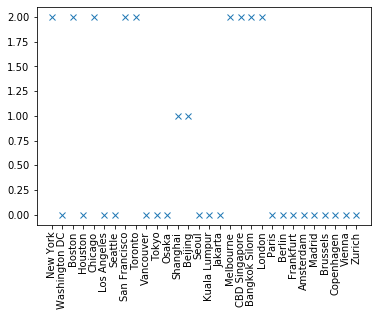

In [72]:
plt.plot(cluster_labels,'x')
plt.xticks(np.arange(30), cities, rotation=90)
plt.show()

### Plot the various clusters on the map to visualise the results

In [73]:
# create map
#map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8)
map_cities = folium.Map(location=[40, 0], zoom_start=2)

# set color scheme for the clusters
colorscheme = ['blue','red','green']

# add markers to the map
for lat, lng, label, cluster in zip(latitudes, longitudes, cities, cluster_labels):
    label = folium.Popup(label+' Cluster '+str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color=colorscheme[cluster],
        fill=True,
        fill_color=colorscheme[cluster],
        fill_opacity=0.7).add_to(map_cities)
       
map_cities